## 8. Plot place field, animal trajectory, and spiking trial by trial

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import cupy as cp
import numpy as np
import numpy.ma as ma
import datajoint as dj
import spyglass as nd
import pandas as pd
import matplotlib.pyplot as plt
import json
import multiprocessing

# ignore datajoint+jupyter async warnings
import warnings
warnings.simplefilter('ignore', category=DeprecationWarning)
warnings.simplefilter('ignore', category=ResourceWarning)

from spyglass.common import (Session, IntervalList,LabMember, LabTeam, Raw, Session, Nwbfile,
                            Electrode,LFPBand,interval_list_intersect)
from spyglass.common import TaskEpoch
import spyglass.spikesorting.v0 as ss

from spyglass.spikesorting.v0 import (SortGroup, 
                                    SortInterval,
                                    SpikeSortingPreprocessingParameters,
                                    SpikeSortingRecording, 
                                    SpikeSorterParameters,
                                    SpikeSortingRecordingSelection,
                                    ArtifactDetectionParameters, ArtifactDetectionSelection,
                                    ArtifactRemovedIntervalList, ArtifactDetection,
                                      SpikeSortingSelection, SpikeSorting,
                                   CuratedSpikeSortingSelection,CuratedSpikeSorting,Curation)
from spyglass.spikesorting.v0.curation_figurl import CurationFigurl,CurationFigurlSelection
from spyglass.spikesorting.v0.spikesorting_curation import MetricParameters,MetricSelection,QualityMetrics
from spyglass.spikesorting.v0.spikesorting_curation import WaveformParameters,WaveformSelection,Waveforms
from spyglass.common.common_position import IntervalPositionInfo, IntervalPositionInfoSelection,IntervalLinearizedPosition

from spyglass.utils.nwb_helper_fn import get_nwb_copy_filename
from pprint import pprint
from spyglass.shijiegu.ripple_detection import removeDataBeforeTrial1
from spyglass.shijiegu.helpers import interpolate_to_new_time
from spyglass.shijiegu.placefield import place_field,placefield_to_peak1dloc
from spyglass.shijiegu.Analysis_SGU import DecodeResultsLinear
warnings.simplefilter("ignore", category=DeprecationWarning)
warnings.simplefilter("ignore", category=ResourceWarning)
warnings.filterwarnings('ignore')

[2024-08-12 10:50:55,590][INFO]: Connecting shijiegu-alt@lmf-db.cin.ucsf.edu:3306
[2024-08-12 10:50:55,831][INFO]: Connected shijiegu-alt@lmf-db.cin.ucsf.edu:3306


In [9]:
from spyglass.shijiegu.helpers import interval_union
from spyglass.shijiegu.Analysis_SGU import TrialChoice,RippleTimes,EpochPos,ExtendedRippleTimes,RippleTimesWithDecode
from spyglass.shijiegu.load import load_run_sessions
from spyglass.shijiegu.singleUnit import (do_mountainSort,electrode_unit,RippleTime2FiringRate,findWaveForms,RippleTime2Index,
                            )
from spyglass.shijiegu.singleUnit import (session_unit,RippleTime2FiringRate,
                                          find_spikes,xcorr,plot_firing_rate)

from spyglass.shijiegu.fragmented import (permute_frag_cont,find_spike_count_ratio,
                            get_nwb_units,find_firing_cross_correlation,classify_cells)
from spyglass.shijiegu.placefield import cell_by_arm

In [4]:
outputFolder='/cumulus/shijie/recording_pilot/eliot/FragmentedReplay/'
isExist = os.path.exists(outputFolder)
if not isExist:
    os.makedirs(outputFolder)

In [5]:
nwb_copy_file_name = "eliot20221022_.nwb"

In [6]:
run_session_ids, run_session_names, pos_session_names = load_run_sessions(nwb_copy_file_name)

*nwb_file_name *epoch    epoch_name     position_inter
+------------+ +-------+ +------------+ +------------+
eliot20221022_ 1         01_Seq2Sleep1  pos 0 valid ti
eliot20221022_ 2         02_Seq2Session pos 1 valid ti
eliot20221022_ 3         03_Seq2Sleep2  pos 2 valid ti
eliot20221022_ 4         04_Seq2Session pos 3 valid ti
eliot20221022_ 5         05_Seq2Sleep3  pos 4 valid ti
eliot20221022_ 6         06_Seq2Session pos 5 valid ti
eliot20221022_ 7         07_Seq2Sleep4  pos 6 valid ti
eliot20221022_ 8         08_Seq2Session pos 7 valid ti
eliot20221022_ 9         09_Seq2Sleep5  pos 8 valid ti
eliot20221022_ 10        10_Seq2Session pos 9 valid ti
eliot20221022_ 11        11_Seq2Sleep6  pos 10 valid t
 (Total: 11)



In [7]:
epoch_num = 3
session_name = run_session_names[epoch_num]
pos_name = pos_session_names[epoch_num]
print(session_name)

08_Seq2Session4


In [8]:
# load spikes
nwb_units_all, sort_group_ids_with_good_cell = session_unit(nwb_copy_file_name,session_name)

# load ripple
ripple_times = pd.DataFrame((RippleTimesWithDecode & 
                             {'nwb_file_name': nwb_copy_file_name, 'interval_list_name': session_name}).fetch1('ripple_times'))

# behavior
StateScript = pd.DataFrame(
        (TrialChoice & {'nwb_file_name':nwb_copy_file_name,'epoch_name':session_name}).fetch1('choice_reward')
    )

In [51]:
cell_list = []
for e in sort_group_ids_with_good_cell:
    for u in nwb_units_all[e].index:
        cell_list.append((e, u))
        
placefields = {}
mobility_spike_counts = {}
all_spike_counts = {}
peak_frs = {}
for row_ind in range(len(cell_list)):
    print(row_ind)
    e = cell_list[row_ind][0]
    u = cell_list[row_ind][1]
    placefield, peak_fr, xbins, ybins, mobility_spike_count, all_spike_count = place_field(nwb_copy_file_name, session_name, pos_name, e, u)
    placefields[(e,u)] = placefield
    peak_frs[(e,u)] = peak_fr
    mobility_spike_counts[(e,u)] = mobility_spike_count
    all_spike_counts[(e,u)] = all_spike_count

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89


In [79]:
cells = [(14,9), (13,7), (20,3), (16,6), (17,13), (23,4)]

### Second kind of plot

In [22]:
pos1d = (IntervalLinearizedPosition() & {'nwb_file_name': nwb_copy_file_name,
                                         'track_graph_name':'4 arm lumped 2023',
                                         'interval_list_name':pos_name,
                                         'position_info_param_name':'default'}).fetch1_dataframe()
trial_1_t = StateScript.loc[1].timestamp_O
trial_last_t = StateScript.loc[len(StateScript)-1].timestamp_O
pos1d = removeDataBeforeTrial1(pos1d,trial_1_t,trial_last_t)

[11:39:45][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


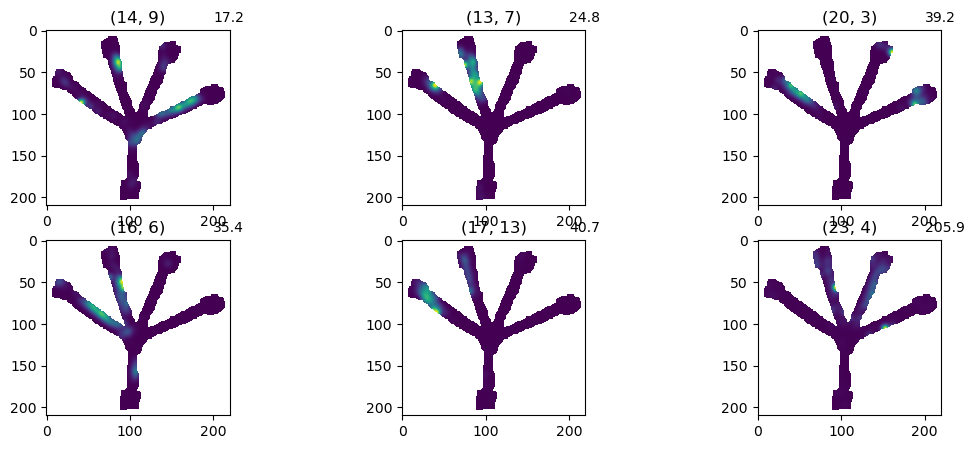

In [80]:
fig, axes = plt.subplots(2,int(np.ceil(len(cells)/2)), figsize = (13,5), squeeze = True)

ind = 0
for cell in cells:
    (e,u) = cell
    
    axes[np.unravel_index(ind, axes.shape)].imshow(placefields[(e,u)])
    axes[np.unravel_index(ind, axes.shape)].set_title(str((e,u)))
    axes[np.unravel_index(ind, axes.shape)].text(200,-10,round(peak_frs[(e,u)],1))
    ind = ind + 1

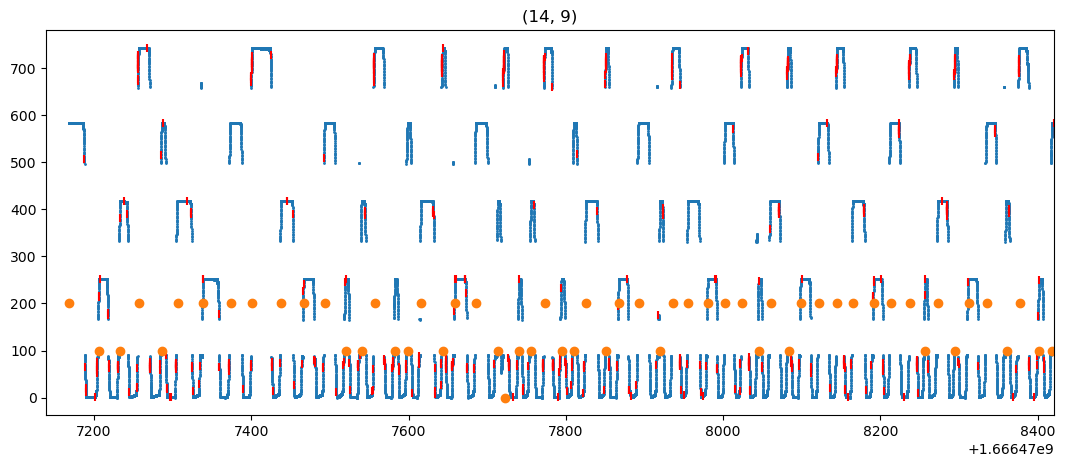

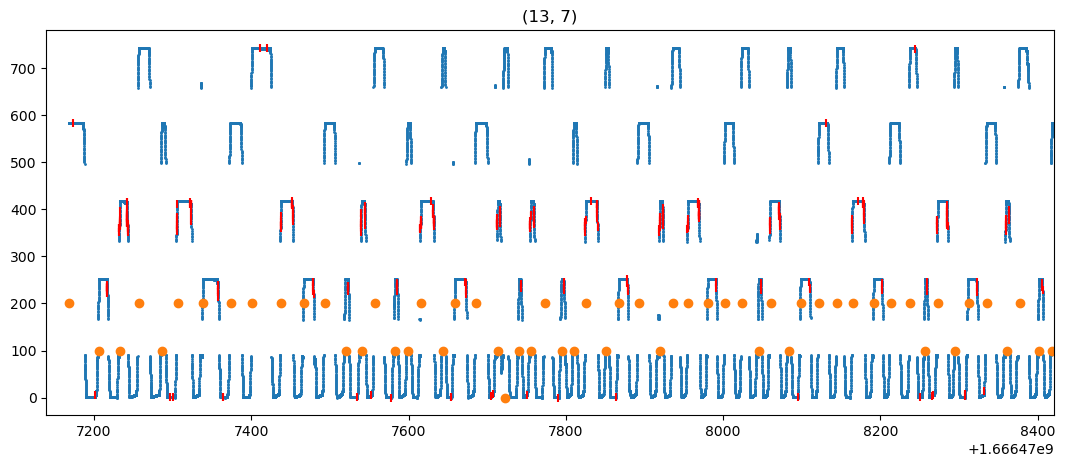

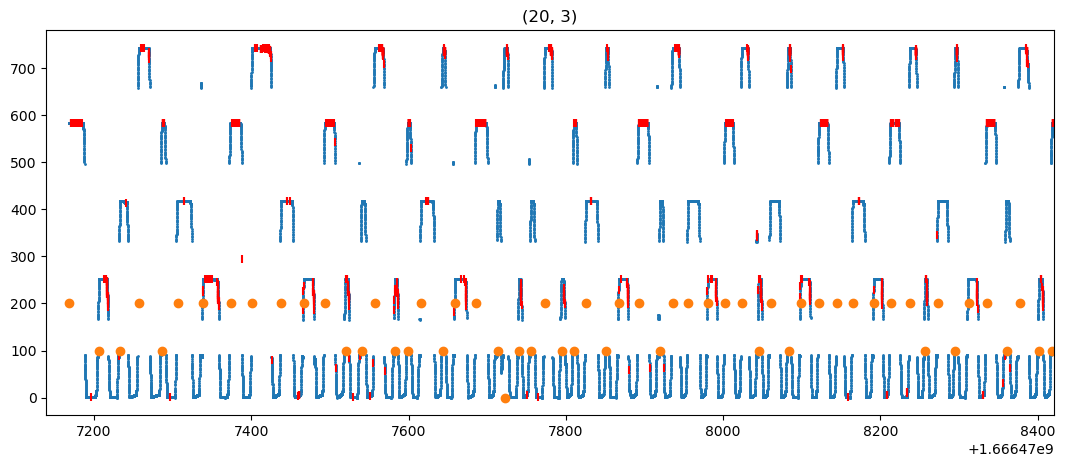

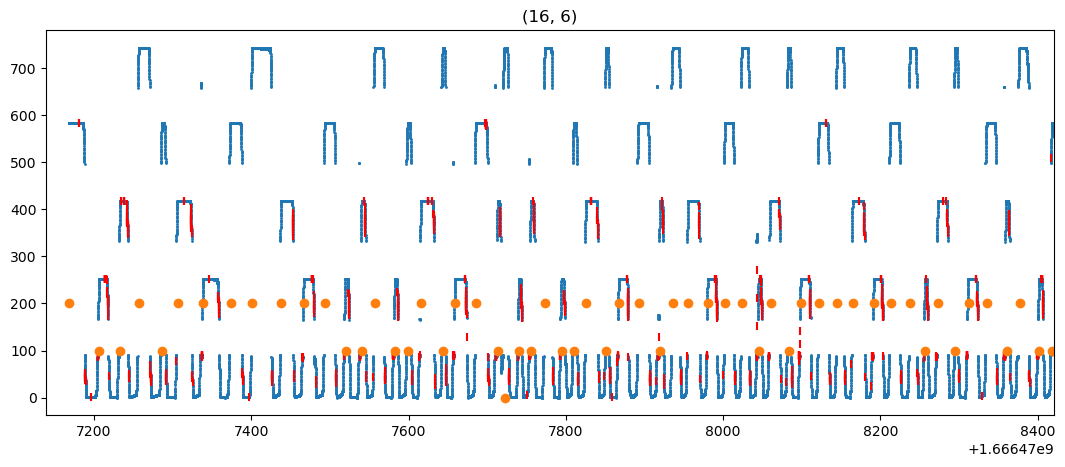

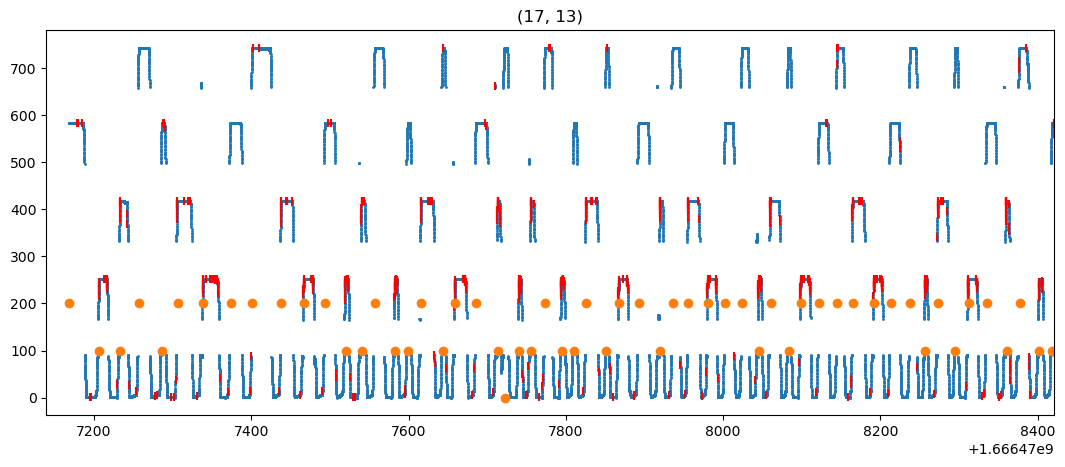

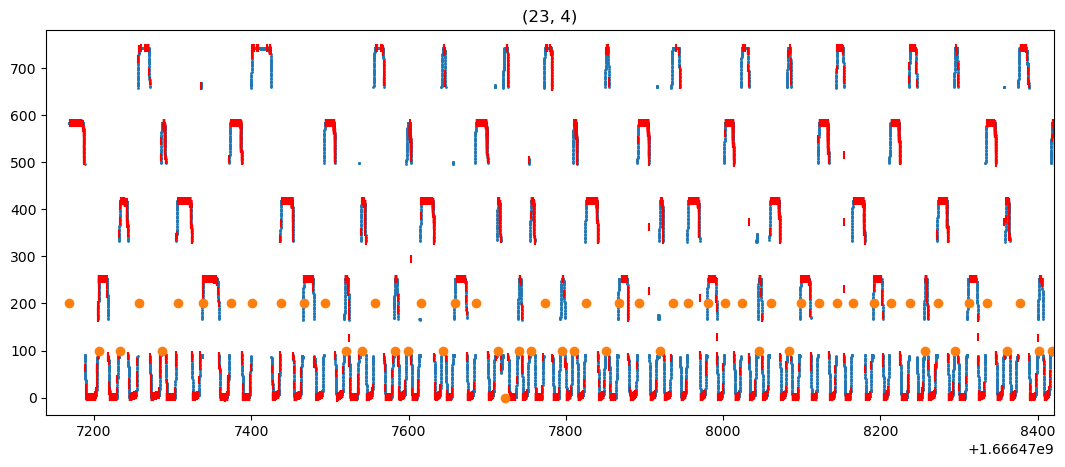

In [81]:
for cell in cells:
    (e,u) = cell
    nwb_units = nwb_units_all[e]
    spike_times = nwb_units.loc[u].spike_times
    spike_times = spike_times[np.logical_and(spike_times>=trial_1_t,
                                           spike_times<=trial_last_t)]
    
    pos1d_spike_time_all = interpolate_to_new_time(pos1d,spike_times)
    
    fig, axes = plt.subplots(1,1, figsize = (13,5), squeeze = True)
    axes.scatter(pos1d.index,pos1d.linear_position,s = 1)
    axes.scatter(spike_times,pos1d_spike_time_all.linear_position,rasterized=True,marker='|',color = 'r')

    axes.scatter(StateScript.timestamp_O, StateScript.rewardNum*100)
    
    axes.set_title(cell)

    axes.set_xlim([pos1d.index[0],pos1d.index[3000*10]])

(1666477139.381233, 1666477993.481221)

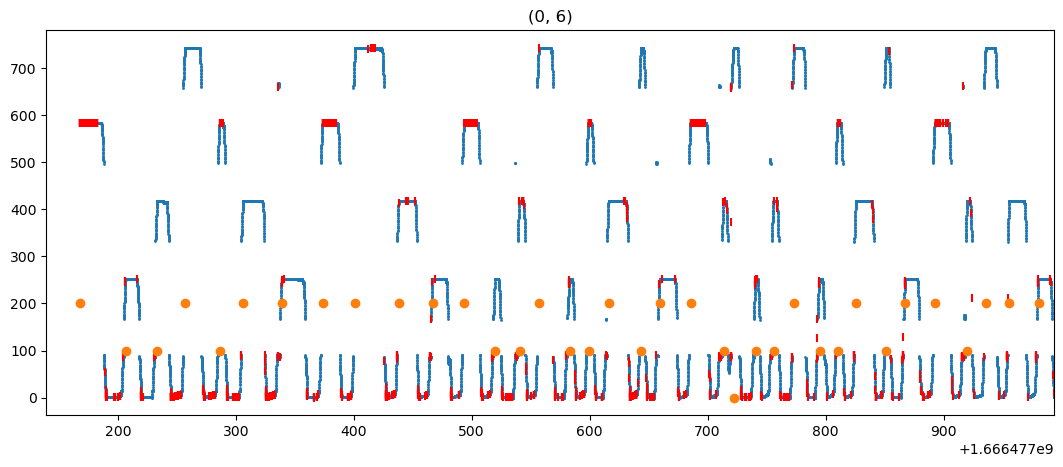

In [82]:
(e,u) = (0,6)
nwb_units = nwb_units_all[e]
spike_times = nwb_units.loc[u].spike_times
spike_times = spike_times[np.logical_and(spike_times>=trial_1_t,
                                           spike_times<=trial_last_t)]
    
pos1d_spike_time_all = interpolate_to_new_time(pos1d,spike_times)
    
fig, axes = plt.subplots(1,1, figsize = (13,5), squeeze = True)
axes.scatter(pos1d.index,pos1d.linear_position,s = 1)
axes.scatter(spike_times,pos1d_spike_time_all.linear_position,rasterized=True,marker='|',color = 'r')
axes.set_title((e,u))

axes.scatter(StateScript.timestamp_O, StateScript.rewardNum*100)

axes.set_xlim([pos1d.index[0],pos1d.index[2000*10]])

In [54]:
StateScript

,timestamp_H,Home,timestamp_O,OuterWellIndex,rewardNum,current,future_H,future_O,past,past_reward
1,1.666477e+09,1.0,1.666477e+09,3.0,2.0,3.0,3.0,1.0,NaN,NaN
2,1.666477e+09,1.0,1.666477e+09,1.0,1.0,1.0,1.0,2.0,3.0,3.0
3,1.666477e+09,1.0,1.666477e+09,2.0,1.0,2.0,2.0,4.0,1.0,3.0
4,1.666477e+09,1.0,1.666477e+09,4.0,2.0,4.0,4.0,3.0,2.0,3.0
5,1.666477e+09,1.0,1.666477e+09,3.0,1.0,3.0,3.0,2.0,4.0,4.0
...,...,...,...,...,...,...,...,...,...,...
78,1.666479e+09,1.0,1.666479e+09,1.0,1.0,1.0,1.0,2.0,4.0,1.0
79,1.666479e+09,1.0,1.666479e+09,2.0,1.0,2.0,2.0,3.0,1.0,1.0
80,1.666479e+09,1.0,1.666479e+09,3.0,2.0,3.0,3.0,4.0,2.0,1.0
81,1.666479e+09,1.0,1.666479e+09,4.0,2.0,4.0,4.0,NaN,3.0,3.0


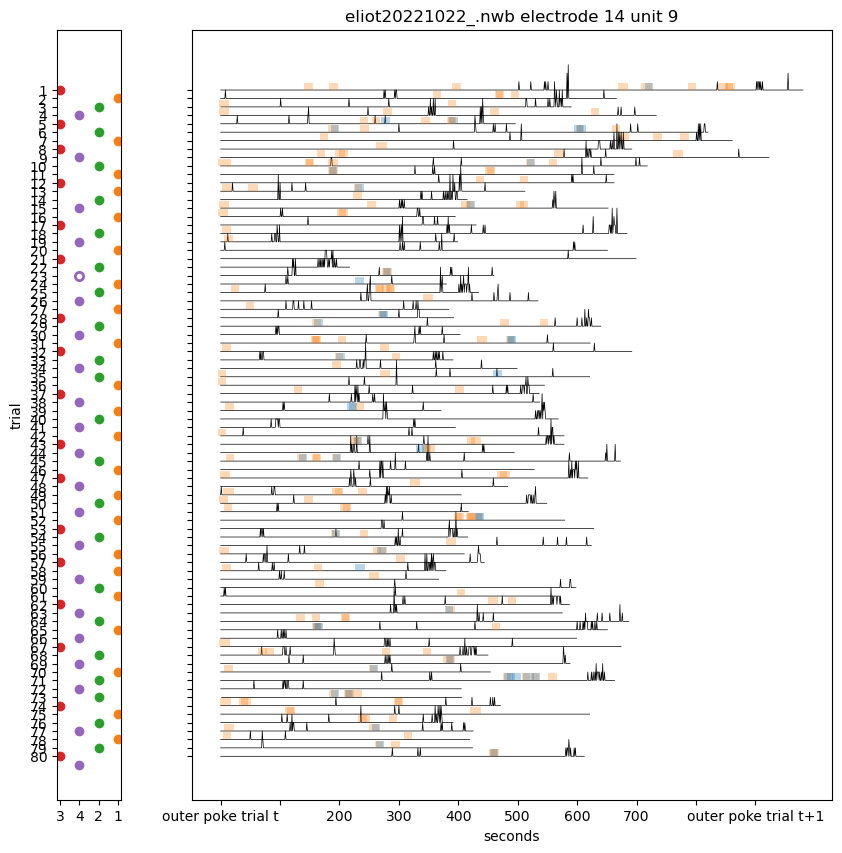

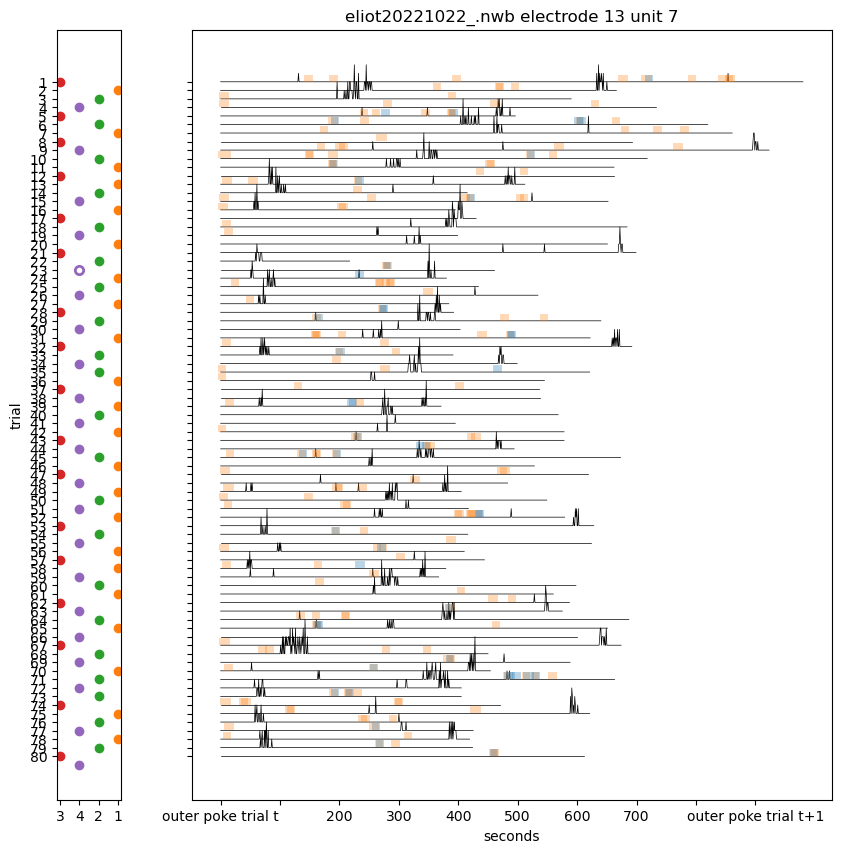

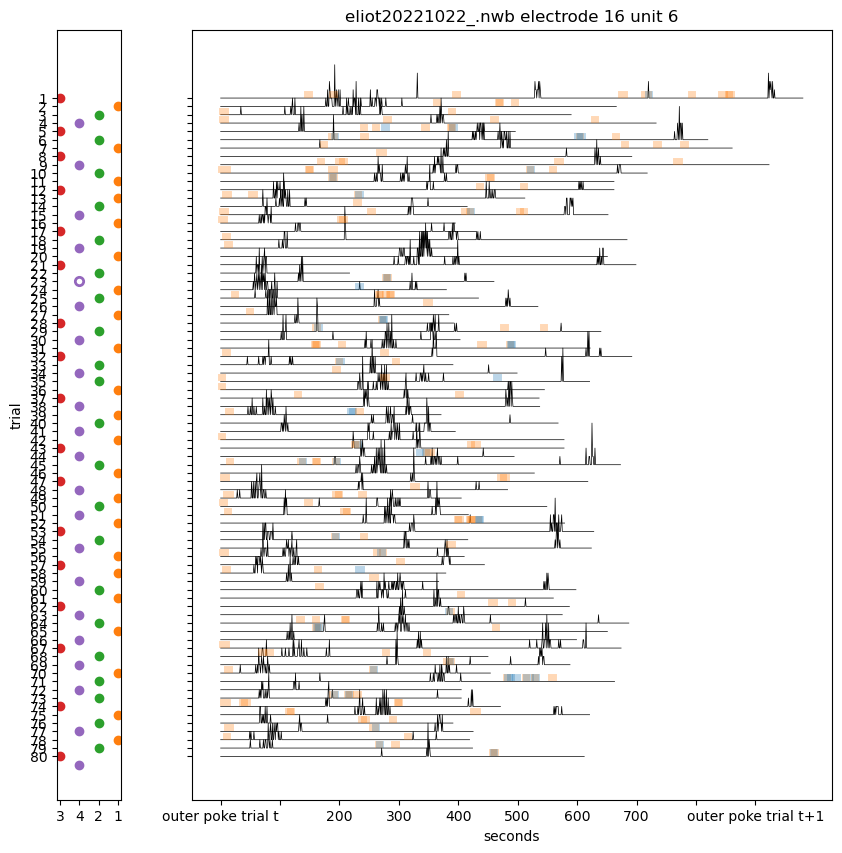

In [61]:
# make data matrix: from outer well to outer well
maxTime = np.nanmax(np.diff(StateScript.timestamp_O[:-1]))
DELTA_T = 0.04

e_old = -1
for cell in cells:
    e = cell[0]
    u = cell[1]
    
    nwb_units = nwb_units_all[e]

    # make firing rate matrix
    firing_rate_matrix = np.zeros((len(StateScript.index[:-2]), int(np.ceil(maxTime/DELTA_T)))) + np.nan
    trials = []

    row_ind = 0
    for t in StateScript.index[:-2]:
        t0 = StateScript.loc[t].timestamp_O
        t1 = StateScript.loc[t+1].timestamp_O
        axis = np.concatenate((np.arange(t0,t1,DELTA_T),np.array([t1])))
    
        spike_times = nwb_units.loc[u].spike_times
        firing_rate_matrix[row_ind,:len(axis)-1],_ = np.histogram(spike_times, axis)
        trials.append(t)
        row_ind = row_ind + 1
        
    #if len(set([(e,u)]).intersection(set(cells_frag)))>0:
    #    savename = 'fragmented_cell_firing_rate_electrode'+str(e)+'_unit'+str(u)
    #else:
    #    savename = 'continuous_cell_firing_rate_electrode'+str(e)+'_unit'+str(u)
    savename = 'cell_firing_rate_electrode'+str(e)+'_unit'+str(u)
    plot_firing_rate(StateScript,nwb_copy_file_name,e,u,
                 DELTA_T,trials,firing_rate_matrix,ripple_times,outputFolder,savename)